# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.Информация о договорах актуальна на 1 февраля 2020.

**Цель исследования**:

Построить модель классификации с максимально большим значением $auc-roc$, по крайней мере до 0.86. Проверить на тестовой выборке. Дополнительно сравнивнить её значение с $F_1$-мерой.

**Ход исследования**:

- загрузка и предварительная обработка данных - описание данных, проверка пропусков, дубликатов, заголовков колонок с признаками, подсчет коэфф.корреляции в phik, поиск аномалий
- разбиение данных на тестовую и тренировочную выборки в соотношении 1:3; кодирование и масштабирование признаков
- создание моделей для решения задачи бинарной классификации, подбор параметров и подсчет метрик; построение *roc_curve*
- тестирование лучшей модели и интерпретация результатов.

## Импорт библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from xgboost import plot_importance

from catboost import CatBoostClassifier
from catboost import cv, Pool

import phik
from phik.report import plot_correlation_matrix
from phik import report

In [2]:
try: 
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:  
    contract = pd.read_csv('/Users/elenamarchenko/Desktop/DS/telecom_final/contract.csv') 
    internet = pd.read_csv('/Users/elenamarchenko/Desktop/DS/telecom_final/internet.csv')
    personal = pd.read_csv('/Users/elenamarchenko/Desktop/DS/telecom_final/personal.csv')
    phone = pd.read_csv('/Users/elenamarchenko/Desktop/DS/telecom_final/phone.csv')

In [3]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [4]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Таблица с персональными данными клиентов содержит информацию о 7043 объектах типов object и int64, где:

- `customerID` - идентификатор клиента 
- `gender`- пол клиента
- `SeniorCitizen`- наличие пенсионного статуса по возрасту 
- `Partner`- наличие супруга(и)
- `Dependents`- наличие иждивенцев

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Таблица, содержащая информацию о договорах клиентов, включает 7043 объекта типов object и float64, где:

- `customerID` - идентификатор клиента
- `BeginDate` - дата начала пользования услугами
- `EndDate` - дата окончания пользования услугами
- `Type` - тип договора
- `PaperlessBilling` - факт выставления счета на электронную почту
- `PaymentMethod` - способ оплаты
- `MonthlyCharges` - ежемесячные траты на услуги
- `TotalCharges` - потрачено всего на услуги

In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Таблица с информацией об интернет-услугах составлена для 5517 объектов типа object, где:

- `customerID` - идентификатор клиента 
- `InternetService` - подключение интернета
- `OnlineSecurity` -  блокировка небезопасных сайтов 
- `OnlineBackup` - облачное хранилище файлов
- `DeviceProtection` - услуга антивирус
- `TechSupport` - линия технической поддержки
- `StreamingTV` - стриминговое телевидение
- `StreamingMovies` - каталог фильмов

In [9]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Таблица с информацией об услугах телефонии включает данные о 6361 объекте типа object, где:

- `customerID` - идентификатор клиента
- `MultipleLines` - наличие возможности ведения параллельных линий во время звонка

In [11]:
personal.duplicated().sum()

0

In [12]:
contract.duplicated().sum()

0

In [13]:
internet.duplicated().sum()

0

In [14]:
phone.duplicated().sum()

0

In [15]:
personal.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Судя по таблице, можно сказать следующее:
    
- столбец пенсионного статуса содержит только 16,2% значений равных 1.
- уникальных значений пользователя столько же, сколько и строк - повторов нет.
- остальные колонки содержат по 2 значения: *Yes* или *No*

In [16]:
contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Согласно данным таблицы имеем:

- уникальных пользователей 7043;
- уникальных дат в `BeginDate` всего 77, а в `EndDate` кроме 5 различных дат встречается значение *No*
- в `TotalCharges` присутствуют нечисловые значения

In [17]:
internet.describe(include='all')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Судя по представленным данным:

- все пользователи в таблице уникальны;
- в остальных колонках всего по 2 значения. Чаще остальных встречаются значения *No* и *Fiber optic* для типа подключения

In [18]:
phone.describe(include='all')

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Согласно данным:

- все пользователи в таблице уникальны;
- колонка `MultipleLines` содержит 2 значсения практически в равном соотношении

Итак, предварительно можно заметить следующее:

* дубликаты отсутствуют;
* пропусков в данных каждой таблицы нет, однако количество объектов, для которых существуют данные, различно. Меньше всего данных об использовании интернет-услуг. Вероятно это обусловлено тем, что каждый клиент имеет определенный набор услуг и не использует все имеющиеся.
* названия колонок необходимо привести к змеиному регистру;
* колонка `EndDate` содержит данные в раличных форматах, необходимо устранить это несоответствие;
* столбец `TotalCharges` с численными данными в *contract* имеет тип object, необходимо обработать эти значения.
* `BeginDate` и `EndDate` для моделирования нам не подходят, их необходимо преобразовать в формат *datetime* и удалить, но прежде из них создадим новый столбец, который будет описывать длительность существования контракта.

## Предобработка данных

### Пропуски и объединение таблиц

In [19]:
personal = personal.rename(columns= {'customerID': 'customer_id', 'SeniorCitizen':  'senior_citizen', 
                                     'Partner':'partner', 'Dependents':'dependents'})
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [20]:
contract = contract.rename(columns= {'customerID':'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date',
                                     'Type': 'type', 'PaperlessBilling': 'paperless_billing', 
                                     'PaymentMethod': 'payment_method', 'MonthlyCharges': 'monthly_charges', 
                                     'TotalCharges':'total_charges'})
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [21]:
internet = internet.rename(columns= {'customerID':'customer_id',  'InternetService':'internet_service',
                                     'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup', 
                                     'DeviceProtection': 'device_protection', 'TechSupport':'tech_support', 
                                     'StreamingTV': 'streaming_tv', 'StreamingMovies':'streaming_movies'})
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [22]:
phone.columns = ['customer_id', 'multiple_lines']

In [23]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

In [24]:
contract['end_date'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [25]:
contract[contract['end_date']=='No']['end_date'].count()

5174

Информация о договорах актуальна на 1 февраля 2020. Как мы видим, большая часть из договоров активна.

Эти данные будут использованы для создания целевого признака: `exited`, где 0- клиент действующий, 1- договор прекращен.

In [26]:
contract['exited'] = contract['end_date'].apply(lambda x: 0 if x == 'No' else 1)

Заменим 5174 значения *No* на '2020-02-01'. Создадим новый столбец, отражающий длительность контракта клиента (в неделях) на момент выгрузки данных.

In [27]:
contract.loc[contract['end_date']=='No','end_date'] = '2020-02-01'

In [28]:
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d %H:%M:%S')

In [29]:
contract['contract_dur_weeks'] = contract['end_date'].dt.to_period('W').astype(int) - \
                                  contract['begin_date'].dt.to_period('W').astype(int)

C:\Users\Anton\AppData\Local\Temp/ipykernel_9516/570848757.py:1: FutureWarning: casting period[W-SUN] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  contract['contract_dur_weeks'] = contract['end_date'].dt.to_period('W').astype(int) - \
C:\Users\Anton\AppData\Local\Temp/ipykernel_9516/570848757.py:2: FutureWarning: casting period[W-SUN] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  contract['begin_date'].dt.to_period('W').astype(int)


In [30]:
contract.head(2)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,contract_dur_weeks
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,4
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,148


In [31]:
contract['total_charges'].sort_values().unique()

array([' ', '100.2', '100.25', ..., '999.45', '999.8', '999.9'],
      dtype=object)

In [32]:
contract[contract['total_charges']== ' ']['type'].count()

11

Столбец `total_charges` содержит 11 пустых значений. Заменим их на 0, т.к. такое значение отсутствует и восстановить пропуск иным способом нельзя. Далее изменим тип столбца на числовой.

In [33]:
contract.loc[contract['total_charges']== ' ', 'total_charges']= '0.0'

In [34]:
contract['total_charges'].sort_values().unique()

array(['0.0', '100.2', '100.25', ..., '999.45', '999.8', '999.9'],
      dtype=object)

In [35]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='raise')

### EDA

**Матрица $\phi_K$ для расчетов попарной корреляции признаков.**

In [36]:
def phi_k(row, a=8, b=6):
    try:
        phik_mtrx = row.drop('customer_id', axis=1).phik_matrix()
    except:
        phik_mtrx = row.phik_matrix()
    
    corr_mrtx = plot_correlation_matrix(phik_mtrx.values, 
                        x_labels=phik_mtrx.columns, 
                        y_labels=phik_mtrx.index, 
                        vmin=0, vmax=1, color_map="viridis", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(a, b)
                                       )
    plt.tight_layout()                                   

In [37]:
def kdeplot(data, xlabel1='', figsize_1=(15, 3), label1='', suptitle1='', ylabel1='', hue1=None):
    
    fig, ax = plt.subplots(figsize=figsize_1)
    fig.suptitle(suptitle1, fontsize=14)
    kdeplot_t = sns.kdeplot(data, palette="hot", alpha=.4, shade=True, label=label1, hue=hue1)

    kdeplot_t.grid(color = 'lightcyan', linewidth = 1, linestyle=':')
    kdeplot_t.set_xlabel(xlabel1, fontsize=12)
    kdeplot_t.set_ylabel(ylabel1, fontsize=12)
        
    return kdeplot_t

In [38]:
def oneplot(df, title1='', xl='', yl='', height=3, width=15):
    
    fig, ax = plt.subplots()
    
    plt.rcParams['font.size'] = '14'
    
    ax.minorticks_on()
    line = sns.lineplot(data=df, color = 'powderblue',linewidth=3, dashes=False)
    
    line.set_title(title1, fontdict={'fontsize': 16})
    line.set_ylabel(yl, fontdict={'fontsize': 12})
    line.set_xlabel(xl, fontdict={'fontsize': 12})
    
    plt.grid(True)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    
    return line

interval columns not set, guessing: ['senior_citizen']


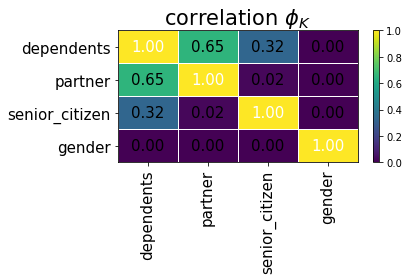

In [39]:
phi_k(personal, 6, 4)

Признаки наличия партнера и иждивенцев сильнее остальных коррелируют друг с другом.

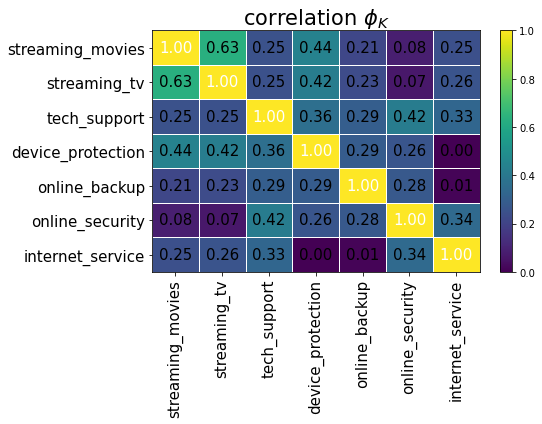

In [40]:
phi_k(internet)

Признаки `streaming_tv` и `streaming_movies` имееют среднюю корреляцию друг с другом.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'exited', 'contract_dur_weeks']


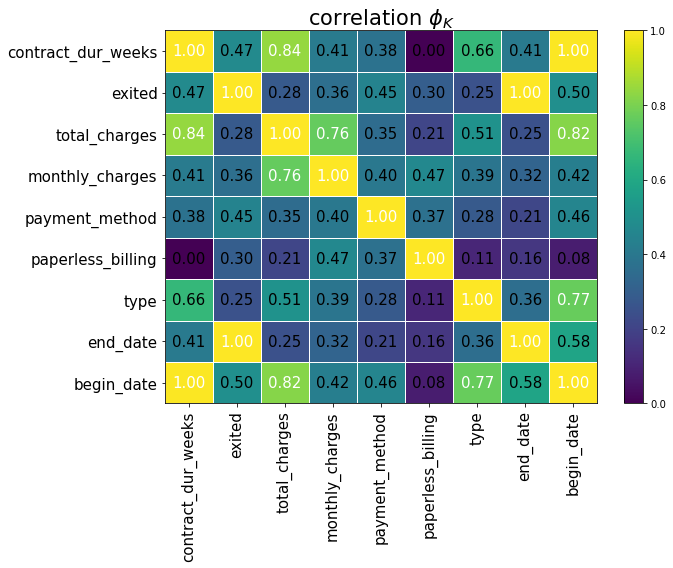

In [41]:
phi_k(contract, 10,8)

<AxesSubplot:title={'center':'Количество пользователей, заключивших договор на услуги'}, xlabel='Дата заключения договора', ylabel='Количество пользователей'>

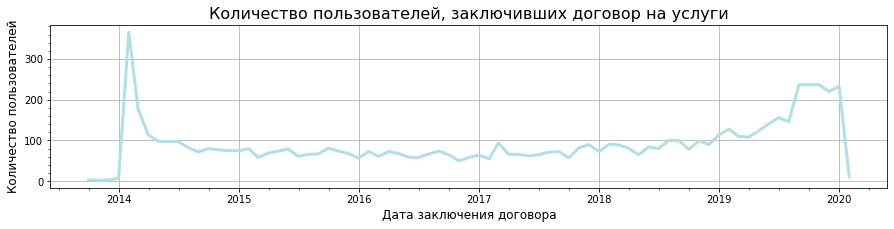

In [42]:
oneplot(contract['begin_date'].value_counts().sort_index(ascending=True),
        title1='Количество пользователей, заключивших договор на услуги', 
        xl='Дата заключения договора', 
        yl='Количество пользователей')

Пик заключенных договоров(более 300) приходится на начало 2014 года. После 2020 года наблюдаем спад.

**Подробнее рассмотрим разброс значений числовых переменных в зависимости от типа договора и факта ухода:**

In [43]:
numb = ['contract_dur_weeks', 'monthly_charges', 'total_charges']

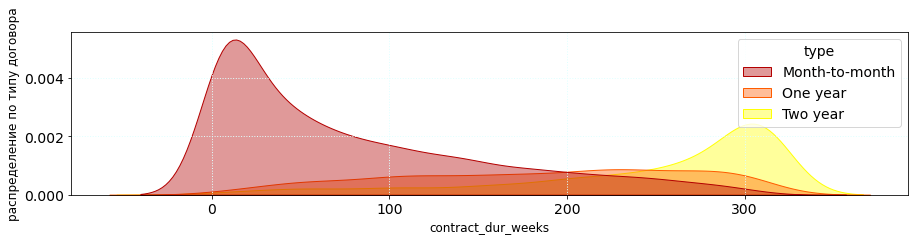

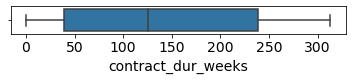

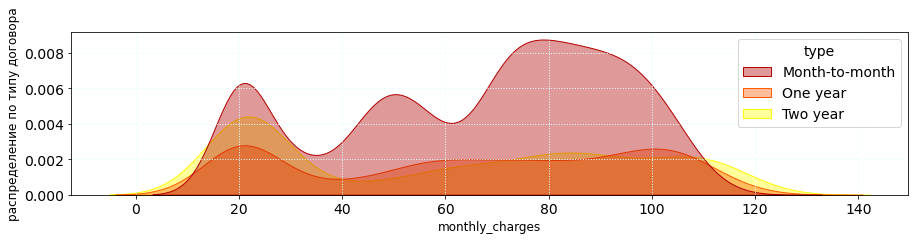

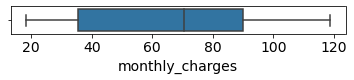

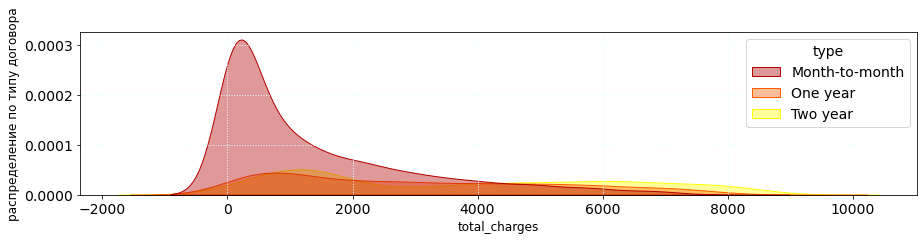

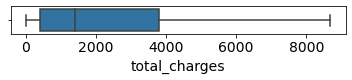

In [44]:
for n in range(len(numb)):
    kdeplot(data=contract[numb[n]], xlabel1=f'{numb[n]}',
            ylabel1= 'распределение по типу договора', hue1 = contract['type'])
    plt.figure(figsize=(6,0.5))
    sns.boxplot(data=contract, x= numb[n])

Распределение значений в `monthly_charges` лежат в интервале [18.25, 118.75], значения смещены вправо. В зависимости от типа договора можно сказать, что клиенты с более длительным сроком контракта в большинстве своем ежемесячно платят меньше. Большинство платежей для договоров с помесячной оплатой находится в промежутке [65, 105].

В `contract_dur_weeks` по состоянию на 1 февраля 2020 года, как и ожидалось, присутствуют договора, оформленные меньше недели назад. Значения смещены влево, значит можно утверждать, что короткосрочных договоров больше. Среднее время договора составляет около 2,4 лет. 
Явных выбросов в этих столбцах нет.

Значения в `total_charges` смещены влево. Среди контрактов сроком на месяц большинство оформлены недавно и оплат по ним не было. Признак сильно коррелирует с месячными платежами и новой колонкой длительности контракта `contract_dur_weeks`. 

**Объединение данных**

Удалим столбцы с датами и столбец с сильной корреляцией `total_charges`, далее объединим всю информацию по клиентам. Поскольку не каждый клиент пользуется всеми услугами, тип объединия "outer", а пропуски заполним значением 'not_provided'.

In [45]:
contract = contract.drop(['begin_date', 'end_date','total_charges'], axis=1)

In [46]:
users = (
    personal.merge(contract, on='customer_id', how='outer')
    .merge(internet, on='customer_id', how='outer')
    .merge(phone, on='customer_id', how='outer')
)

In [47]:
users.shape

(7043, 19)

In [48]:
users.isna().sum()

customer_id              0
gender                   0
senior_citizen           0
partner                  0
dependents               0
type                     0
paperless_billing        0
payment_method           0
monthly_charges          0
exited                   0
contract_dur_weeks       0
internet_service      1526
online_security       1526
online_backup         1526
device_protection     1526
tech_support          1526
streaming_tv          1526
streaming_movies      1526
multiple_lines         682
dtype: int64

In [49]:
users = users.fillna('not_provided')

In [50]:
users.isna().sum()

customer_id           0
gender                0
senior_citizen        0
partner               0
dependents            0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
exited                0
contract_dur_weeks    0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
multiple_lines        0
dtype: int64

Итак, больше всего пропусков приходилось на столбцы из таблицы *internet*. Пропуски устранены.

**Рассмотрим распределение остальных показателей в разрезе ухода\неухода.**

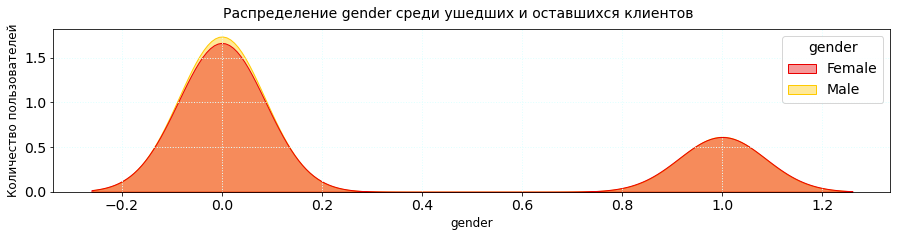

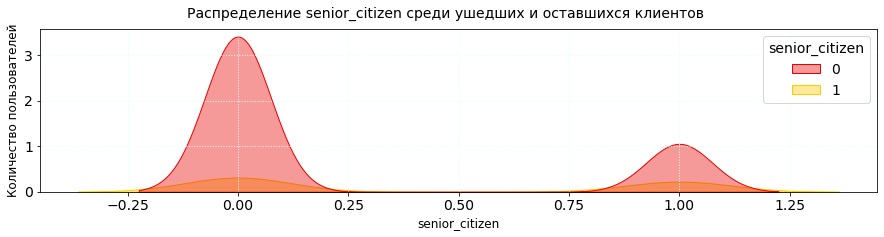

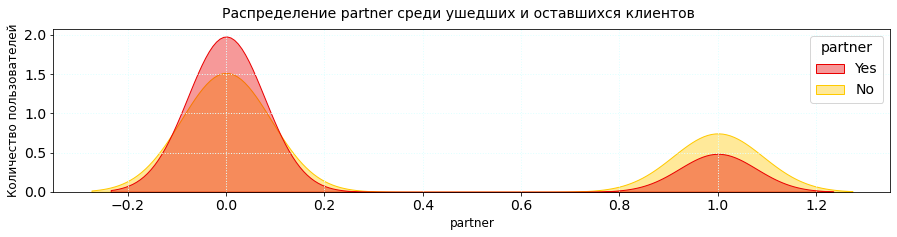

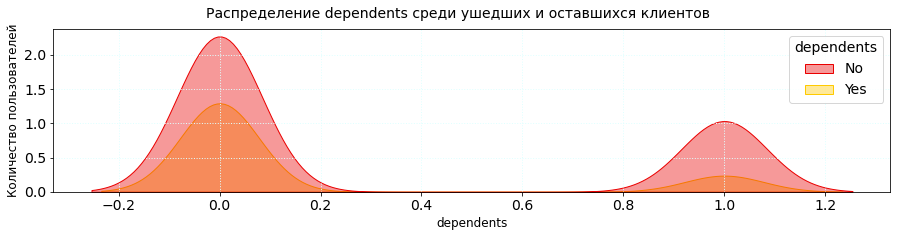

In [52]:
for col in personal.columns.drop('customer_id'):
    kdeplot(data=users['exited'], suptitle1=f'Распределение {col} среди ушедших и оставшихся клиентов', xlabel1=f'{col}', 
            ylabel1='Количество пользователей',  hue1=users[col])
plt.show()

Как можно увидеть по графикам, персональные данные клиентов не влияют на факт их ухода.

In [53]:
f_list = ['paperless_billing', 'multiple_lines', 'device_protection',
          'internet_service','payment_method','tech_support']

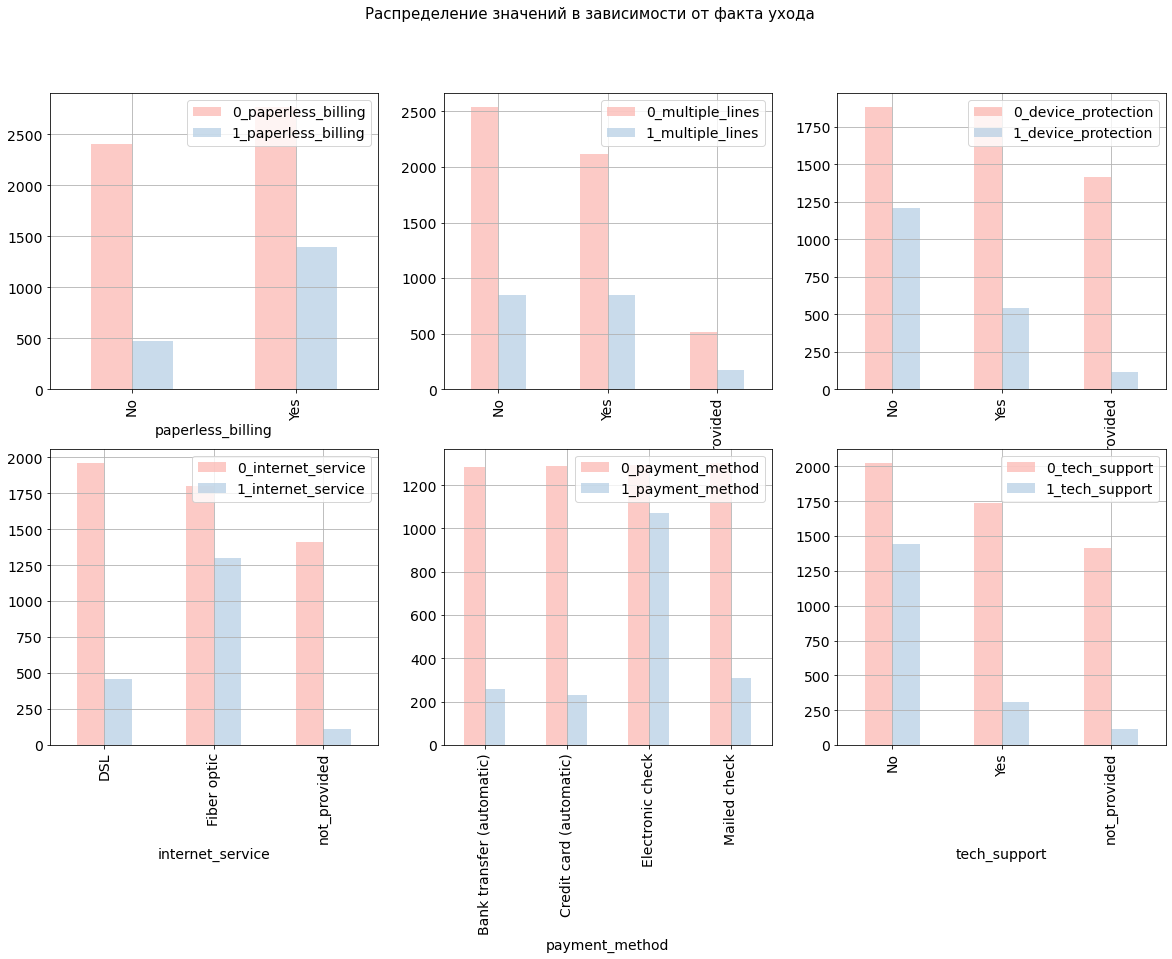

In [54]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.ravel()

for col in f_list:
    pvt = users.pivot_table(columns = 'exited', values = ['customer_id'], index = col, aggfunc = 'count')
    pvt.columns = ['0_'+col, '1_'+col]
    ax = pvt.plot.bar(alpha = 0.7, grid = True, color = sns.color_palette("Pastel1").as_hex(),ax=axs[f_list.index(col)])

plt.suptitle('Распределение значений в зависимости от факта ухода', fontsize = 15)
plt.show()

Можно заметить, что среди ушедших клиентов было почти в 3 раза больше безбумажных способов оплаты. При этом, больше всего ушедших клиентов использовала электронный чек как средство оплаты. Так же больше всего ушедшие клиенты использовали тип интернет-соединения *Fiber_optic* и не пользовались услугами `tech_support` и `device_protection`.

In [55]:
users = users.drop('customer_id', axis=1)

**Вывод**

На этапе предобработки сделано следующее:

- названия столбцой переведены в змеиный регистр;
- создан столбец с целевым признаком`exited` на основе столбца `end_date`;
- добавлены данные о длительности контракта в неделях `contract_dur_weeks`;
- удалены столбцы с датами и именами клиентов;
- все данные объединены в таблицу *users*, где пропуски заменены на значение "not_provided";
- так же удален сильно коррелирующий признак `total_charges` и номер клиента`customer_id`.

Приступим к обучению моделей.

## Обучение моделей

Разобьем данный в соотношении 3:1 для дальнейшего обучения:

In [56]:
train, test = train_test_split(users, test_size= 0.25, random_state = 41022)

In [57]:
features_train = train.drop(['exited'], axis=1)
target_train= train['exited']

In [58]:
features_test = test.drop(['exited'], axis=1)
target_test= test['exited']

In [59]:
features_train.shape, features_test.shape

((5282, 17), (1761, 17))

Закодируем категориальные признаки ниже.

In [60]:
cat_features = ['gender', 'partner', 'dependents', 'type', 'paperless_billing', \
                'payment_method', 'internet_service', 'multiple_lines','online_security',\
                'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [61]:
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)], remainder='passthrough')

In [62]:
encoder = full_pipeline.fit(features_train)
x_train = encoder.transform(features_train)
x_test = encoder.transform(features_test)

Создадим таблицы для записи метрик.

In [63]:
predictions = pd.DataFrame(columns = ['y_true'], data= target_train.values)

In [64]:
models = pd.DataFrame(columns = ['parameters', 'roc_auc_train', 'f1_train'])

In [65]:
def model_metrics(df, model_name: str, roc_auc_train: float, f1_train: float, parameters: np.array):
    
    df.loc[model_name, 'parameters'] = parameters
    df.loc[model_name, 'roc_auc_train'] = round(roc_auc_train, 5)
    df.loc[model_name, 'f1_train'] = round(f1_train, 5)

**XGBClassifier**

In [66]:
%%time
xgb = XGBClassifier(random_state = 41022, class_weight = 'balanced')
params= {'booster': ['dart', 'gbtree'],
         'eta':  [0.1, 0.3], 
         'gamma': np.arange(0.1, 0.2, 1),
         'objective': ['binary:logistic'], 
         'eval_metric': ['auc'],
         'verbosity': [0],
         'use_label_encoder': [False]
        }

xgb_model = GridSearchCV(xgb, params, scoring= 'roc_auc', cv=5)
xgb_model.fit(x_train, target_train)
print('Гиперпараметры модели:', xgb_model.best_params_)
print('Оценка roc_auc на тренировочных данных:', xgb_model.best_score_)

Гиперпараметры модели: {'booster': 'dart', 'eta': 0.1, 'eval_metric': 'auc', 'gamma': 0.1, 'objective': 'binary:logistic', 'use_label_encoder': False, 'verbosity': 0}
Оценка roc_auc на тренировочных данных: 0.8553265832855258
Wall time: 19.4 s


In [67]:
predictions['xgb_pred'] = xgb_model.predict(x_train)

In [68]:
xgb_f1_train = f1_score(target_train, predictions['xgb_pred'])
print('Оценка F1 на тренировочных данных:', xgb_f1_train)

Оценка F1 на тренировочных данных: 0.7385466034755134


In [69]:
model_metrics(models, 'XGBClassifier', xgb_model.best_score_, xgb_f1_train, [xgb_model.best_params_])

**LGBMClassifier**

In [73]:
%%time
lgbm = LGBMClassifier(random_state = 41022)
params= {'boosting_type': ['gbdt', 'dart'],
         'n_estimators': [100, 200],
         'learning_rate': [0.1, 0.05, 0.015],
         'objective': ['binary'],
         'is_unbalance': [True],
         'metric': ['auc']
        }

lgbm_model = GridSearchCV(lgbm, params, scoring= 'roc_auc', cv=5)
lgbm_model.fit(x_train, target_train)
print('Гиперпараметры модели:', lgbm_model.best_params_)
print('Оценка roc_auc на тренировочных данных:', lgbm_model.best_score_)

Гиперпараметры модели: {'boosting_type': 'gbdt', 'is_unbalance': True, 'learning_rate': 0.05, 'metric': 'auc', 'n_estimators': 100, 'objective': 'binary'}
Оценка roc_auc на тренировочных данных: 0.8560739512768757
Wall time: 10.2 s


In [74]:
predictions['lgbm_pred'] = lgbm_model.predict(x_train)

In [75]:
lgbm_f1_train = f1_score(target_train, predictions['lgbm_pred'])
print('Оценка F1 на тренировочных данных:', lgbm_f1_train)

Оценка F1 на тренировочных данных: 0.7308714918759232


In [76]:
model_metrics(models, 'LGBMClassifier', lgbm_model.best_score_, lgbm_f1_train, [lgbm_model.best_params_])

**CatBoostClassifier**

In [77]:
X = ['gender', 'senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 'payment_method', 
     'monthly_charges', 'contract_dur_weeks', 'internet_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv','streaming_movies']

y = ['exited']

In [78]:
train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

In [79]:
test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features   
                 )

In [80]:
#c_model = CatBoostClassifier(random_state = 41022)
#params=  {#'cat_features': cat_features,
#          "objective": ["Logloss","CrossEntropy"],
#          'eval_metric': ['AUC'],
#          'learning_rate': [0.15, 0.03,0.1],
#          'l2_leaf_reg': [1,3,5],
#          'depth': [4, 6, 10],
#          'iterations': [500, 700, 900],
#          'verbose': [500]
#         }
#cbm = GridSearchCV(c_model, params, scoring= 'roc_auc', cv=5, verbose=False)
#cbm.fit(x_train, target_train)
#print('Гиперпараметры модели:', cbm.best_params_)
#print('Оценка roc_auc на тренировочных данных:', cbm.best_score_)

In [84]:
%%time
params=  {'cat_features': cat_features,
          "objective": 'Logloss',
          'eval_metric': 'AUC',
          'learning_rate': 0.15,
          'l2_leaf_reg': 1,
          'depth': 5,
          'random_state': 41022,
          'iterations': 500,
          'verbose': 500
         }
cat_model = CatBoostClassifier(**params)
cat_model.fit(train_data)

0:	total: 205ms	remaining: 1m 42s
499:	total: 10.9s	remaining: 0us
Wall time: 11.1 s


In [85]:
cat_roc_train = roc_auc_score(train[y], cat_model.predict_proba(train_data)[:, 1])
cat_roc_train

0.9402188242106385

In [86]:
predictions['cat_pred'] = cat_model.predict(train_data)

In [87]:
cat_f1_train = f1_score(train['exited'], predictions['cat_pred'])
print('Оценка F1 на тренировочных данных:', cat_f1_train)

Оценка F1 на тренировочных данных: 0.7075184702303348


In [88]:
model_metrics(models, 'CatBoostClassifier', cat_roc_train, cat_f1_train, [params])

In [89]:
models

,parameters,roc_auc_train,f1_train
XGBClassifier,"[{'booster': 'dart', 'eta': 0.1, 'eval_metric'...",0.85533,0.73855
LGBMClassifier,"[{'boosting_type': 'gbdt', 'is_unbalance': Tru...",0.85607,0.73087
CatBoostClassifier,"[{'cat_features': ['gender', 'partner', 'depen...",0.94022,0.70752


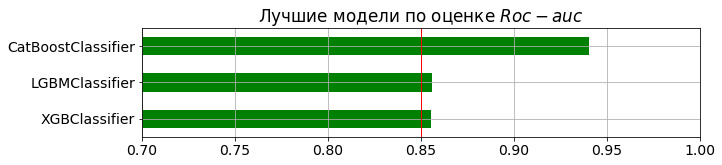

In [90]:
models['roc_auc_train'].sort_values(ascending=True).plot.barh(color = 'g',
    grid=True, xlim=(0.7,1), figsize=(10,2)).set_title('Лучшие модели по оценкe $Roc-auc$')
plt.axvline(x=0.85, c='r', lw=1)

Text(0.5, 1.0, 'Лучшие модели по оценкe $F_1$')

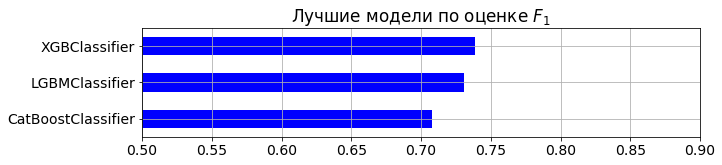

In [91]:
models['f1_train'].sort_values(ascending=True).plot.barh(color = 'b',
    grid=True, xlim=(0.5,0.9), figsize=(10,2)).set_title('Лучшие модели по оценкe $F_1$')

In [92]:
predictions.describe()

,y_true,xgb_pred,lgbm_pred,cat_pred
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,0.263347,0.216017,0.377509,0.172283
std,0.440491,0.411565,0.484810,0.377662
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


Как видно из предсказаний, модель *LGBMClassifier* переобучилась, количество значений **1** превышает истинные.

**Вывод**

На данном этапе были рассмотрены три модели классификации. Результаты моделирования записаны в датафрейм. Согласно графикам, оценки $roc-auc$ на тренировочных данных преодолели порог 0.85, при этом значение выше всех у модели *CatBoostClassifier*. Относительно метрики $f1$ лучшей стала модель *XGBClassifier*.

Далее посчитаем оценку лучшей модели на тестовых данных.

## Тестирование лучшей модели

In [93]:
cat_roc_test = roc_auc_score(test[y], cat_model.predict_proba(test_data)[:, 1])
cat_roc_test

0.8833457801896054

In [94]:
def pr_roc(model, x_test, y_test):
    proba_test = model.predict_proba(x_test)
    proba_one_test = proba_test[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, proba_one_test)
    fpr, tpr, thresholds = roc_curve(y_test, proba_one_test)
    
    _, ax = plt.subplots(1, 2, figsize=(15,7))
    ax[0].plot(recall, precision)
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Кривая P-R')
    
    ax[1].plot(fpr, tpr)
    ax[1].plot([0, 1], [0, 1], linestyle='--')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC-кривая")
    plt.suptitle("Метрики PR и ROC для модели Catboost", fontsize=15)
    plt.show()    

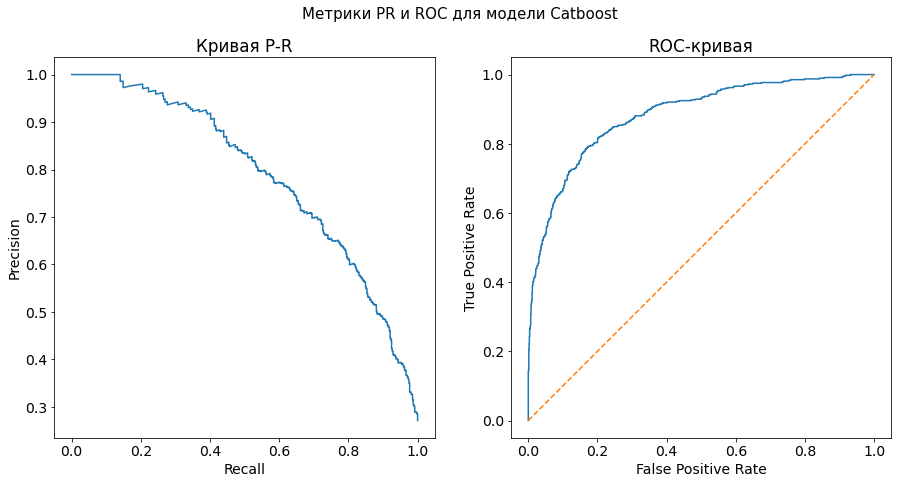

0.6326950515566357

In [95]:
pr_roc(cat_model, test[X], test[y])
average_precision_score(predictions['y_true'],predictions['cat_pred'])

Итак, метрика $average-precision-score$ модели, отражающая среднюю точность оценок прогноза, приняла значение 0.63, $roc-auc$ на тестовых данных имеет значение 0.8833.

Рассмотрим важность каждого признака для модели:

In [96]:
cat_imp = pd.DataFrame(
    {'imp':cat_model.get_feature_importance()}, features_train.columns).sort_values(by='imp', ascending = False)

In [97]:
cat_imp.head(5)

,imp
contract_dur_weeks,40.101953
monthly_charges,17.168526
type,9.589299
payment_method,5.271030
online_security,4.494666


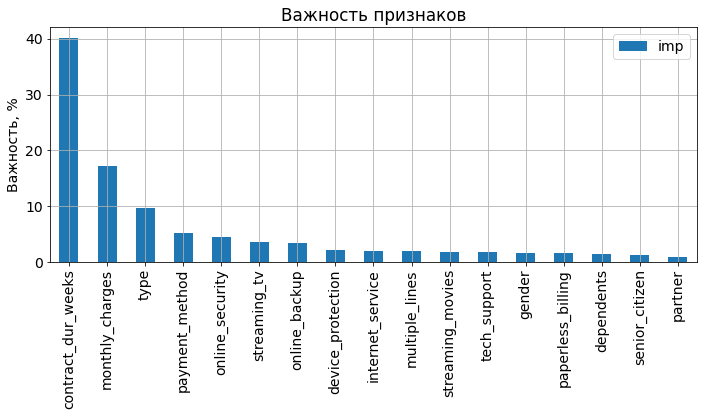

In [98]:
fig, ax = plt.subplots(figsize=(10,6))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
plt.grid()
fig.tight_layout()

Оставим только признаки со значением больше 2,5%. Обучим модель на этих признаках

In [99]:
new_features = np.array(cat_imp.query('imp > 2.5').index)
new_features

array(['contract_dur_weeks', 'monthly_charges', 'type', 'payment_method',
       'online_security', 'streaming_tv', 'online_backup'], dtype=object)

In [100]:
new_cat_features = np.delete(new_features, 1)

In [101]:
%%time
params=  {'cat_features': new_cat_features,
          "objective": 'Logloss',
          'eval_metric': 'AUC',
          'learning_rate': 0.15,
          'l2_leaf_reg': 1,
          'depth': 5,
          'random_state': 41022,
          'iterations': 500,
          'verbose': 500
         }
new_cat_model = CatBoostClassifier(**params)
new_cat_model.fit(features_train[new_features], target_train)

0:	total: 17.8ms	remaining: 8.88s
499:	total: 8.61s	remaining: 0us
Wall time: 9.04 s


In [102]:
cat_roc_train_imp = roc_auc_score(target_train, new_cat_model.predict_proba(features_train[new_features])[:, 1])
cat_roc_train_imp

0.8949245258232928

In [103]:
cat_roc_train  < cat_roc_train_imp

False

In [104]:
cat_roc_test_imp = roc_auc_score(target_test, new_cat_model.predict_proba(features_test[new_features])[:, 1])
cat_roc_test_imp

0.8704950805023528

In [105]:
cat_roc_test < cat_roc_test_imp

False

**Вывод**

Таким образом, тестовая метрика модели *CatBoostClassifier* выше значения 0.88. 
При исследовании важности признаков выделены 7: `ontract_dur_weeks`, `monthly_charges`, `type`, `payment_method`, `online_security`, `streaming_tv`, `online_backup`. Обучение модели *CatBoost* только на этих признаках показала ухудшение метрики.

**Общий вывод**

В начале исследования было выяснено, что:

* дубликаты в данных  отсутствуют;
* пропусков в данных каждой таблицы нет. Меньше всего данных об использовании интернет-услуг. 

На этапе предобработки сделано следующее:

- названия столбцой переведены в змеиный регистр;
- создан столбец с целевым признаком`exited` на основе столбца `end_date`;
- добавлены данные о длительности контракта в неделях `contract_dur_weeks`;
- удалены столбцы с датами и именами клиентов;
- все данные объединены в таблицу *users*, где пропуски заменены на значение "not_provided";
- так же удален сильно коррелирующий признак `total_charges`

В процессе обучения моделей были рассмотрены три модели классификации, значение оценки $roc-auc$ выше всех у модели *CatBoostClassifier*. Относительно метрики $f1$ лучшей стала модель *XGBClassifier*.

При тестировании оценка модели *CatBoostClassifier* достигла значения 0.8833. Выделены ключенвые признаки модели : `ontract_dur_weeks`, `monthly_charges`, `type`, `payment_method`, `online_security`, `streaming_tv`, `online_backup`.